# Метрики качества бинарной классификации

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

как измерять качество чёткого ответа в задачах бинарной классификации

Оценка качества производится на контрольной выборке

параметр, варьируя который, мы будем получать то или иное разбиение на два класса. Этот параметр часто называют порогом, или точкой отсечения (cut-off value). В зависимости от него будут получаться различные величины ошибок I и II рода.

Пусть классификатор выдаёт метку класса. Используем принятые в этом блоге обозначения: yi – метка i-го объекта, ai – ответ на этом объекте нашего алгоритма, m – число объектов в выборке.

* Объекты с меткой **1** (отток) будем называть положительными.
* Объекты с меткой **0** (лояльные абоненты) будем называть отрицательными

In [3]:
# истинные значения классов
y_true = np.array([0, 0, 0, 1, 1, 1, 0])

# вероятности принадлежности к классам, предсказанные алгоритмом
y_predict_proba = np.array([0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0])


df = pd.DataFrame({'true': y_true , 
                   'predict_proba': y_predict_proba},
                   index = ['object_{}'.format(i) for i in range(1, 8)])
df

,true,predict_proba
object_1,0,0.5
object_2,0,0.1
object_3,0,0.2
object_4,1,0.6
object_5,1,0.2
object_6,1,0.3
object_7,0,0.0


**Выбор порога (threshold) для относения к классу**

Алгоритм возвращает вещественное значение - вероятность принадлежности к классу 1, которое с помощью порога (**threshold**) переводится в бинарный ответ: $ a(x) = [b(x) > t]$

Варьируя данный параметр, мы будем получать то или иное разбиение на два класса. В зависимости от него будут получаться различные величины ошибок I и II рода.

In [4]:
threshold = 0.23
y_predict = (y_predict_proba >= threshold).astype('int')

df['predict'] = y_predict

In [5]:
df

,true,predict_proba,predict
object_1,0,0.5,1
object_2,0,0.1,0
object_3,0,0.2,0
object_4,1,0.6,1
object_5,1,0.2,0
object_6,1,0.3,1
object_7,0,0.0,0


В нашей формулировке actual состоит из нулей и единиц, а predicted - из величин из интервала [0, 1] (вероятности класса 1). Такие векторы удобно показывать на scatter plot.

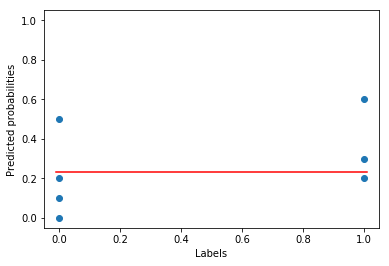

In [6]:
plt.scatter(y_true, y_predict_proba)
plt.plot([-0.01, 1.01], [threshold, threshold], c='red')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("Labels")
plt.ylabel("Predicted probabilities")
plt.show()

Чаще всего интервалы накладываются - тогда нужно аккуратно подбирать порог.

Самый неправильный алгоритм делает все наоборот: поднимает вероятности класса 0 выше вероятностей класса 1. Если так произошло, стоит посмотреть, не перепутались ли метки 0 и 1 при создании целевого вектора из сырых данных.



 Если алгоритм боится ошибок false positive, то он будет чаще делать предсказания, близкие к нулю. Аналогично, чтобы избежать ошибок false negative, логично чаще предсказывать большие вероятности.

### Loss

In [7]:
from sklearn.metrics import log_loss

Log_loss вычисляет правдоподобие меток в actual с вероятностями из predicted, взятое с противоположным знаком:

$log\_loss(actual, predicted) = - \frac 1 n \sum_{i=1}^n (actual_i \cdot \log (predicted_i) + (1-actual_i) \cdot \log (1-predicted_i))$, $n$ - длина векторов.

Соответственно, эту метрику нужно минимизировать. 

интерпретировать величину достаточно сложно: метрика не достигает нуля никогда и не имеет верхней границы. Поэтому даже для идеального алгоритма, если смотреть только на одно значение log_loss, невозможно понять, что он идеальный.

In [8]:
def logloss_metric(y_true, y_predict_proba, eps=1e-15):

    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))


In [9]:
logloss_metric(y_true, y_predict_proba).sum()

NameError: name 'y_pred' is not defined

In [10]:
#######################################

Для начала разберемся с метриками, оценивающие качество уже после бинаризации по порогу T, то есть сравнивающие два бинарных вектора: actual и predicted.

### Сonfusion matrix (Таблица сопряженности)

In [11]:
from sklearn.metrics import confusion_matrix

|              _| Algorithm_1     | Algorithm_0    |
|-------------  |--------------   | ------------   |
| **True_1**    | True Positives  | False Negatives|
| **True_0**    | False Positives | True Negatives |


* **True Positives (TP)** — верно классифицированные положительные примеры (так называемые истинно положительные случаи);

* **True Negatives (TN)** — верно классифицированные отрицательные примеры (истинно отрицательные случаи);

* **False Positives (FP)** — отрицательные примеры (True_0), классифицированные как положительные (Algorithm_1) (ошибка I рода). В нашей задаче по определению оттока абонентов, ошибкой первого рода будет принятие лояльного абонента за уходящего;

* **False Negatives (FN)** — положительные примеры (True_1), классифицированные как отрицательные (Algorithm_0) (ошибка II рода). Соответственно, ошибкой второго рода будет являться "пропуск" уходящего абонента.

In [12]:
cm = confusion_matrix(y_true, y_predict, labels = [1, 0])
cm

array([[2, 1],
       [1, 3]])

In [13]:
tp, fn, fp, tn = cm.ravel()
(tp, fn, fp, tn)

(2, 1, 1, 3)

### Accuracy (доля правильных ответов)

In [37]:
from sklearn.metrics import accuracy_score

$$accuracy = \frac {TN + TP}{TN + TP + FN + FP}\$$

In [38]:
# 1-й способ
acc = (tn + tp) / (tn + fp + fn + tp)
acc

0.7142857142857143

In [39]:
# 2-й способ
accuracy_score(y_true, y_predict)

0.7142857142857143

### Precision (точность)

In [40]:
from sklearn.metrics import precision_score

_Точность показывает, какая доля объектов, определенная классификатором как положительные, действительно являются положительной_

$$precision = \frac {TP}{TP + FP}\$$

In [41]:
# 1-й способ
pr = tp / (tp + fp)
pr

0.6666666666666666

In [42]:
# 2-й способ
precision_score(y_true, y_predict, labels = [0, 1])

0.6666666666666666

Этот показатель не дает отнести все объекты к одному положительному классу

### Recall (полнота)

In [43]:
from sklearn.metrics import recall_score

_Полнота показывает, какая доля положительных объектов была определена классификатором_

$$recall = \frac {TP}{TP + FN}\$$

In [44]:
# 1-й способ
rec = tp / (tp + fn)
rec

0.6666666666666666

In [45]:
# 2-й способ
recall_score(y_true, y_predict)

0.6666666666666666

### Precision_Recall_Curve

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score

Кривая строится в координатах полнота (Recall) и точность (Precision). 

In [47]:
prs, recs, thresholds = precision_recall_curve(y_true, y_predict_proba, pos_label=1)
pr_metric = np.round(average_precision_score(y_true, y_predict_proba), 2)

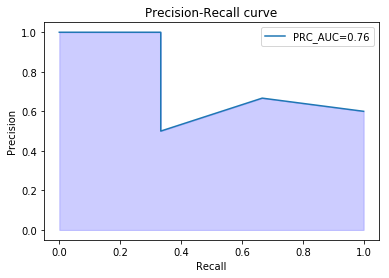

In [48]:
plt.plot(recs, prs, label='PRC_AUC={}'.format(pr_metric))
plt.fill_between(recs, prs, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.title('Precision-Recall curve')
plt.show()

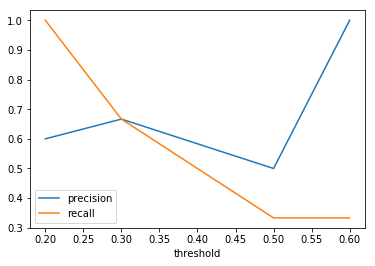

In [49]:
plt.plot(thresholds, prs[:-1], label="precision")
plt.plot(thresholds, recs[:-1], label="recall")
plt.xlabel("threshold")
plt.legend()
plt.show()

При увеличении порога мы делаем меньше ошибок FP и больше ошибок FN, поэтому одна из кривых растет, а вторая - падает. По такому графику можно подобрать оптимальное значение порога, при котором precision и recall будут приемлемы.

Оговоримся, что приемлемые значения precision и recall определяются предметной областью. Например, в задаче определения, болен ли пациент определенной болезнью (0 - здоров, 1 - болен), ошибок false negative стараются избегать, требуя recall около 0.9. Можно сказать человеку, что он болен, и при дальнейшей диагностике выявить ошибку; гораздо хуже пропустить наличие болезни.

### F1-score

In [50]:
from sklearn.metrics import f1_score

Гармоническое среднее точности и полноты

$$f1 = \frac {2 * precision * recall}{precision + recall}\$$

In [53]:
# 1-й способ
f1 = 2*pr*rec/(pr+rec)
f1

0.6666666666666666

In [54]:
# 2-й способ
f1_score(y_true, y_predict)

0.6666666666666666

### ROC_AUC

AUC ROC – площадь под ROC-кривой – часто используют для оценивания качества упорядочивания алгоритмом объектов двух классов.

AUC ROC равен доле пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил,

Выбору порога соответствует выбор точки на ROC-кривой. 

результат работы алгоритма на фиксированной тестовой выборке визуализируют с помощью ROC-кривой (ROC = receiver operating characteristic, иногда говорят «кривая ошибок»), а качество оценивают как площадь под этой кривой – AUC (AUC = area under the curve). 

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является AUC-ROC (или ROC AUC) — площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve ). Данная кривая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR):

При построении ROC-кривой (receiver operating characteristic) происходит варьирование порога бинаризации вектора вероятностей, и вычисляются величины, зависящие от числа ошибок FP и FN.

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

а) Доля объектов положительного класса мы правильно классифицировали

$$TPR = \frac {TP}{TP + FN}$$

б) Доля объектов отрицательного класса, которых мы ошибочно отнесли к положительному

$$FPR = \frac {FP}{FP + TN}$$

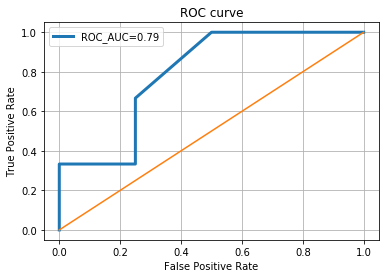

In [57]:
fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba, pos_label=1)
roc_auc_metric = np.round(roc_auc_score(y_true, y_predict_proba), 2)

plt.plot(fpr, tpr, lw=3, label='ROC_AUC={}'.format(roc_auc_metric))
plt.plot([0, 1], [0, 1])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC curve')
plt.grid()
plt.show()

Каждая точка на графике соответствует выбору некоторого порога. Площадь под кривой в данном случае показывает качество алгоритма (больше — лучше),

Чем больше объектов в выборке, тем более гладкой выглядит кривая (хотя на самом деле она все равно ступенчатая).



После того, как кривая построена, удобно выбирать порог бинаризации, в котором будет достигнут компромисс между FP или FN. Порог соответствует точке на кривой. Если мы хотим избежать ошибок FP, нужно выбирать точку на левой стороне квадрата (как можно выше), если FN - точку на верхней стороне квадрата (как можно левее). Все промежуточные точки будут соответствовать разным пропорциям FP и FN.

Чем выше показатель AUC, тем качественнее классификатор, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.

Идеальному соответствует ROC-кривая, проходящая через точку (0, 1), площадь под ней равна 1. Наихудшему – ROC-кривая, проходящая через точку (1, 0), площадь под ней – 0. Случайному – что-то похожее на диагональ квадрата, площадь примерно равна 0.5.

<img align="center" src="../img/pic2.png"/>

http://www.navan.name/roc/

Оптимизировать AUC ROC напрямую затруднительно по нескольким причинам:

эта функция недифференцируема по параметрам алгоритма,
она в явном виде не разбивается на отдельные слагаемые, которые зависят от ответа только на одном объекте (как происходит в случае log_loss).

### Заключение

Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок.
Часто в реальной практике стоит задача найти оптимальный (для заказчика) баланс между этими двумя метриками. Классическим примером является задача определения оттока клиентов.
Очевидно, что мы не можем находить всех уходящих в отток клиентов и только их. Но, определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдет с большей вероятностью, так как мы ограничены в ресурсах колл-центра.